In [ ]:
import torch 
import pandas as pd
from torch.utils.data import random_split,DataLoader,TensorDataset
import seaborn as sns
import random
import torch.nn as nn
import torch.optim as optim # contiene algoritmos de optimización como SGD o Adam
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score


# Semilla general
# torch.manual_seed(42)
# random.seed(42)

## Problema 1

In [2]:
dataset = pd.read_csv("dataset.csv")
dataset.drop("#",axis=1,inplace=True)
dataset

,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...
795,Diancie,Rock,Fairy,600,50,100,150,100,150,50,6,True
796,DiancieMega Diancie,Rock,Fairy,700,50,160,110,160,110,110,6,True
797,HoopaHoopa Confined,Psychic,Ghost,600,80,110,60,150,130,70,6,True
798,HoopaHoopa Unbound,Psychic,Dark,680,80,160,60,170,130,80,6,True


### Descripción del dataset  
En el siguiente bloque describa el dataset a utilizar. También es necesario hacer un análisis exploratorio de los datos.
Responda como mínimo las siguientes preguntas:
- ¿De qué trata el dataset?
- ¿Cuáles son las clases de salida?
- ¿Está preparado para poder ser introducido a una red neuronal?
- ¿Cuantas carácteristicas tiene?
- Etc.


#### Dataset: Pokemon
Los datos que estamos viendo en este dataset son las distintas estadisticas que poseen los pokemon de 1era a 6ta generacion, mostrando su nombre y sus tipos correspondientes, ademas de especificar si este pokemon es legendario o no

Las caracteristicas que posee el dataset tiene los siguientes valores:
* **Name:** Nombre del Pokemon en cuestion
* **Type 1:** Primer tipo del pokemon, que siempre contiene un valor (Fire, Fairy, Steel, Water, Grass, Dragon, Ice, Poison, Bug, Normal, Flying, Fighting, Ghost, Psychic, Dark, Ground, Rock y Electric)
* **Type 2:** Tipo secundario del pokemon, que puede no tener.
* **HP:** (Health Points) Cantidad de vida que el pokemon posee
* **Attack:** Valor base que tienen los pokemon para el ataque fisico
* **Defense:** Valor base de defensa que tienen los pokemon para resistir ataques fisicos
* **Sp. Atk:** Valor base de ataque especial que tienen los pokemon para inflingir daño especial
* **Sp. Def:** Valor base de defensa especial que tienen los pokemon para resistir ataques especiales
* **Speed:** Valor base de un pokemon para definir cual de los pokemones se mueve primero en batalla
* **Total:** Suma total de todas las estadisticas de un pokemon, donde normalmente los que son sobre 600 son legendarios
* **Generation:** Generacion a la cual pertenece el pokemon, refiriendonos a los juegos que salieron el mismo año (Ej: Rojo, Azul y Amarillo salieron el mismo año y se consideran 1era generacion)
* **Legendary:** Valor que define si el pokemon en cuestion es legendario o no (True: Legendario / False: No legendario)

Dependiendo de cual sea el estudio, el valor de salida pueden ser distintas, como por ejemplo, los tipos de el pokemon con el que normalmente se le puede asociar una estadistica, como por ejemplo el tipo acero tiene principalmente tipo acero, asi mismo, si veo un pokemon con una stat mayor en la defensa, lo mas probable es que sea acero, o viendo las estadisticas totales, puedo analizar si el pokemon en cuestion es o no legendario

El Dataset de por si no posee un valor que tenga 0 en alguna parte, ya que no puede existir una estadistica en 0, tampoco los nombres pueden ser vacio, el unico valor que puede llegar a existir que sea un valor no leible seria el NaN en el segundo tipo, que esto implica que el pokemon solo tiene un tipo.

In [3]:
# Verificar valores nulos en otras columnas
columnas = ["Total", "HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed", "Generation", "Legendary"]
valores_nulos = dataset[columnas].isnull().sum()

# Mostrar los resultados
print(valores_nulos)

valores_cero = dataset[columnas].eq(0).sum()

# Mostrar los resultados
print(valores_cero)
# En legendary es normal ya que es verdadero o falso, no un valor numerico

Total         0
HP            0
Attack        0
Defense       0
Sp. Atk       0
Sp. Def       0
Speed         0
Generation    0
Legendary     0
dtype: int64
Total           0
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary     734
dtype: int64


#### Analisis exploratorio

In [4]:
# ABRIMOS Y ALMACENAMOS EL DATASET SOLO PARA ANÁLISIS 
df = pd.read_csv("dataset.csv") 
df.drop("#",axis=1,inplace=True)
df.drop("Name",axis=1,inplace=True)
df.drop("Type 1",axis=1,inplace=True)
df.drop("Type 2",axis=1,inplace=True)

In [5]:
df.describe()

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
count,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.00000
mean,435.10250,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500,3.32375
std,119.96304,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474,1.66129
min,180.00000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.00000
25%,330.00000,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000,2.00000
50%,450.00000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000,3.00000
75%,515.00000,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,5.00000
max,780.00000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000,6.00000


Del describe() podemos observar que:

**Media**

* Total promedio: 435, es decir los stats en promedio es de 435
* HP promedio: 69, la vida promedio es de 69
* Attack: 79.
* Defense, Sp. Atk, Sp. Def, Speed, rondan los 68 - 74.

**Desviación estandar**

* Total tiene una desviación estándar **alta**, lo que confirma que hay pokémon muy básicos (stats bajas) y otros muy fuertes (stats altos)
* HP, Attack, Defense, Sp. Atk, Sp. Def., Speed tienen una variablidad de más o menos 30, podría sugerir una buena diversidad de estadisticas en general.

**Min y Max**

* HP: Algunos pokémon tienen HP de 1 o hasta de 255.
* Attack: Algunos tienen como minimo 5 de ataque, mientras que otros tienen hasta 190.
* Defense: Algunos tienen como minimo 5 de defensa, mientras que otros tienen hasta 230.
* Speed: Algunos tienen como minimo 5 de velocidad, mientras que otros tienen hasta 180.

**Percentiles**

un 50% del dataset tiene menos de 450 de total, pero el máximo es de 780, esto puede sugerir una cola derecha, influenciada por pokémon muy fuertes. Lo mismo ocurre con los stats individualmente.


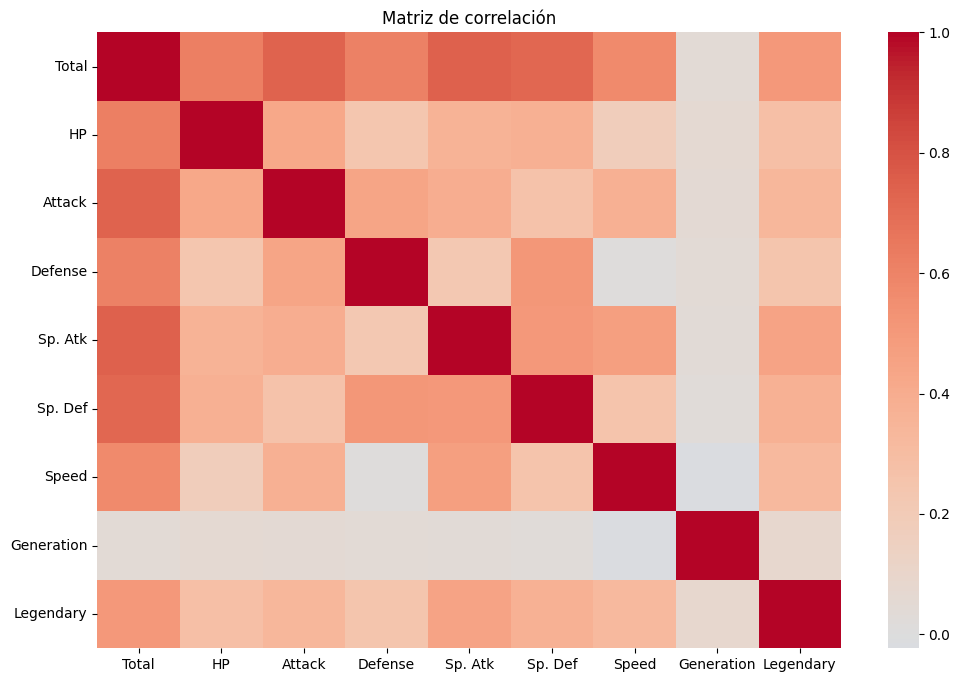

In [6]:
corr = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Matriz de correlación')
plt.show()


In [7]:
print("Correlación mínima")
corr.min().min()

Correlación mínima


np.float64(-0.02312106042589799)

Podemos observar que hay una gran correlación positiva entre varias de las columnas del dataset, lo cual es llamativo, ya que podemos a su vez observar que no hay correlaciones negativas significativas, la correlación más negativa es de -0.023, lo cual es prácticamente nulo, es decir, **no hay relaciones inversas fuertes** en el dataset.

Podemos notar que:

* Hay una correlación más o menos fuerte entre **Total y Attack, Sp. Atk, Sp. Def.** Es decir, Si los valores de ataque, Sp. Atk (Valor base de ataque especial) y/o Sp. Def (valor base de defensa especial) aumentan, tambien lo hace el Total (Suma total de las estadisticas) , lo cual hace sentido.
  De igual forma esto ocurre (aunque en un poco menor medida que las anteriores) con HP, Defense, Speed.
* Generation no tiene ninguna correlación ni negativa ni positiva con ninguna de las variables.
* Legendary está correlacionada positivamente con Total, y moderadamente con Sp. Atk, lo que sugiere que los legendarios suelen tener Sp. Atk y Stats en general altos.
* Defense y Sp. Def Alta correlación, es decir, aquellos que tienen una buena defensa, también tienden a tener una buena defensa especial.
* Correlación moderada entre Sp. Atk y Speed, aquellos con un buen ataque especial, tambien suelen ser veloces.

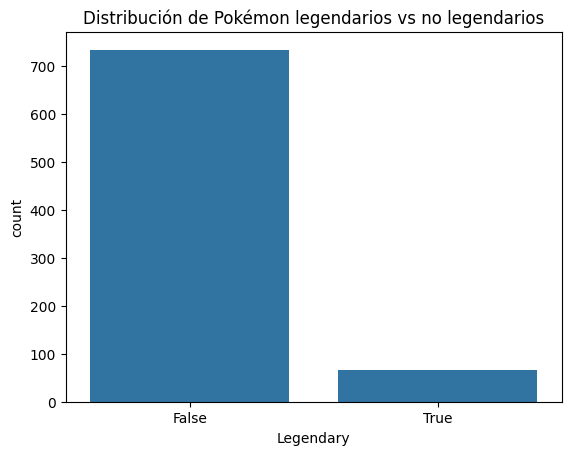

In [8]:
sns.countplot(data=df, x='Legendary')
plt.title('Distribución de Pokémon legendarios vs no legendarios')
plt.show()

Podemos observar que la cantidad de legendarios son una minoria dentro del dataset, este desequilibrio en las clases podría afectar directamente al entrenamiento de la red neuronal, y tener riesgo de tender a predecir siempre "no lengedario" y aun así tener 90% de precisión. Será clave observar las métricas de recall, falsos negativos, y no confiar solo en la precisión global.

### Preparación del dataset  
En el siguiente bloque realice la preparación del dataset. Esto incluye:
- Paso a tensores de PyTorch
- División del dataset en train y test
- Carga de los datos en DataLoader
- Otros pasos que considere necesarios

In [9]:
""" PREPARANDO EL DATASET """
# Eliminar columnas innecesarias
dataset.drop("Name", axis=1, inplace=True)
dataset.drop("Generation",axis=1,inplace=True)

# Aplicamos codificación de variables categoricas
dataset = pd.get_dummies(dataset, columns=["Type 1", "Type 2"])

In [ ]:
# Seleccionamos y escalamos

"""Para medirlo segun todas las estadisticas"""
#X = dataset.drop("Legendary", axis=1)

"""Para medirlo segun el total"""
X = dataset[["Total"]]

y = dataset["Legendary"].to_numpy() # Transformamos a numpy para usar reshape

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

""" Dividimos el dataset """
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3) # 30% para Test, 70% para Train

""" Convertimos a tensores """
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

""" Carga de los datos e DataLoader"""
train = TensorDataset(X_train_tensor, y_train_tensor) # Juntamos todo el dataset de entrenamiento
train_loader = DataLoader(train, batch_size=32, shuffle=True) 

test  = TensorDataset(X_test_tensor, y_test_tensor) # Juntamos todo el dataset de testeo
test_loader  = DataLoader(test, batch_size=32)

# OBS: utilizamos batch_size=32 para mantener un equilibrio 
# (al ser mas o menos pequeños, es más rápido pero a la vez mantiene estabilidad)

In [27]:
print("Legendarios en entrenamiento:", y_train_tensor.sum().item())
print("No legendarios:", len(y_train_tensor) - y_train_tensor.sum().item())


Legendarios en entrenamiento: 46.0
No legendarios: 514.0


### Implementación de la red neuronal
En el siguiente bloque implemente la arquitectura de red neuronal que predecirá si un Pokémon es legendario o no.

In [28]:
# Red neuronal: 2 entradas → 4 neuronas ocultas → 1 salida
input_dim = X_train_tensor.shape[1] # 44
hidden_dim = 88
output_dim = 1

model = nn.Sequential(
    nn.Linear(input_dim, hidden_dim), # capa oculta 
    nn.ReLU(),                        # función de activación
    nn.Linear(hidden_dim, 64),        # capa oculta
    nn.ReLU(),
    nn.Linear(64, output_dim),        # salida con 1 neurona
    nn.Sigmoid()                      # función de activación de salida
)

In [29]:
print(X_train_tensor.shape[1])

1


En el siguiente bloque cree una instancia de la red neuronal y defina la función de pérdida y el optimizador. Justifique la elección de la función de pérdida y el optimizador.

In [30]:
""" Función de perdida """
criterion = nn.BCELoss()  # (Binary Cross-Entropy Loss)
# Justificación: Usada para clasificación binaria, el cual es este caso (legendario - no legendario)

""" Optimizador """
optimizer = optim.SGD(model.parameters(), lr=0.01)
# Justificación: Pensamos que podría ser una buena opción para el dataset
# este actualiza los parametros dando pequeños pasos en la dirección que reduce el error
# Se decidió utilizar un learning rate (lr) pequeño para dar pasos mas estables (aunque más lentos)

En el siguiente bloque entrene la red neuronal.

In [31]:
num_epochs = 350

for epoch in range(num_epochs):
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f"Época {epoch}, pérdida: {loss.item():.4f}")

Época 0, pérdida: 0.5784
Época 10, pérdida: 0.1678
Época 20, pérdida: 0.1151
Época 30, pérdida: 0.2109
Época 40, pérdida: 0.1063
Época 50, pérdida: 0.1107
Época 60, pérdida: 0.0208
Época 70, pérdida: 0.0668
Época 80, pérdida: 0.1659
Época 90, pérdida: 0.3582
Época 100, pérdida: 0.0385
Época 110, pérdida: 0.0455
Época 120, pérdida: 0.0647
Época 130, pérdida: 0.0382
Época 140, pérdida: 0.1526
Época 150, pérdida: 0.1663
Época 160, pérdida: 0.0319
Época 170, pérdida: 0.1279
Época 180, pérdida: 0.0134
Época 190, pérdida: 0.0948
Época 200, pérdida: 0.0101
Época 210, pérdida: 0.1671
Época 220, pérdida: 0.0642
Época 230, pérdida: 0.0870
Época 240, pérdida: 0.0345
Época 250, pérdida: 0.0544
Época 260, pérdida: 0.1286
Época 270, pérdida: 0.1692
Época 280, pérdida: 0.1391
Época 290, pérdida: 0.0312
Época 300, pérdida: 0.0893
Época 310, pérdida: 0.0420
Época 320, pérdida: 0.1379
Época 330, pérdida: 0.1069
Época 340, pérdida: 0.1671


En el siguiente bloque evalue el rendimiento de la red (Métricas de evaluación, matriz de confusión, etc.) y responda las siguientes preguntas:
- ¿Cuántas épocas fueron necesarias para converger?
- ¿Cuál fue la precisión final?
- ¿El entrenamiento de su red neuronal fue exitoso?
- ¿Cuales son los ejemplos que más confunde a la red neuronal? Responda el porqué de acuerdo a su conocimiento del dataset.



In [32]:
# probamos con test
with torch.no_grad(): # Desactivamos el cálculo de la gradiente
    y_test_pred = model(X_test_tensor) # Hace una predicción sobre los datos de prueba
    y_test_pred_labels = (y_test_pred > 0.4).float() # Convierte la probabilidad en una clasificación binaria
    acc = (y_test_pred_labels == y_test_tensor).float().mean() # Compara las predicciones con las etiquetas reales
    print(f"\nPrecisión en test: {acc.item():.4f}")



Precisión en test: 0.9292


In [34]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Convertimos tensores a NumPy
y_true = y_test_tensor.numpy()
y_pred = y_test_pred_labels.numpy()

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
print("\nMatriz de confusión:")
print(cm)

# Precisión y recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print(f"Precisión: {precision:.4f}")
print(f"Recall: {recall:.4f}")


Matriz de confusión:
[[208  12]
 [  5  15]]
Precisión: 0.5556
Recall: 0.7500


In [35]:
print("Cantidad de legendarios reales:", y_test_tensor.sum().item())
correctos = ((y_test_pred_labels == 1) & (y_test_tensor == 1)).sum().item()
print("Cantidad de legendarios predichos correctamente:", correctos)


Cantidad de legendarios reales: 20.0
Cantidad de legendarios predichos correctamente: 15


In [19]:
torch.save(model.state_dict(), 'modelo_campeon.pth')
# Solo por si acaso

### Conclusiones
En el siguiente bloque escriba sus conclusiones sobre el trabajo realizado. Además responda las siguientes preguntas:
- Sobre la matriz de confusión, si usted fuese un entrenador Pokémon, ¿Elegiría a Pokémon ubicados en FP o FN para su equipo? ¿Por qué?
- Entrene un modelo de aprendizaje automático diferente al de la red neuronal (eg. RF) y compare los resultados. ¿Cuál fue el mejor modelo? ¿Por qué?

### Conclusion
1. Para el punto uno principalmente se podria priorizar los valores que existen dentro de los falsos negativos, pero tambien podriamos considerar el uso de los falsos positivos, en ambos casos se consideran dos cosas, los falsos negativos serian los pokemones legendarios que no identifico bien, cosa que podria significar que no entra en el criterio para identificarlo normalmente, pero esto podria no considerar a buenos pokemones legendarios, aunque es mucho mas peligroso ya que significaria una probabilidad de un pokemon legendario malo, asi que siguiendo esto mismo, el falso positivo podria ser una mejor opcion, ya que seria un pokemon no legendario que cumple los requisitos para considerarse un pokemon legendario, asi que en terminos de riesgo, seria mejor escogedr a los falsos positivos.

In [36]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train.ravel())

y_pred_rf = rf.predict(X_test)


acc_rf = accuracy_score(y_test, y_pred_rf)
cm_rf = confusion_matrix(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)

print(f"Precisión RF: {acc_rf:.4f}")
print("Matriz de confusión RF:")
print(cm_rf)
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")

Precisión RF: 0.9667
Matriz de confusión RF:
[[212   8]
 [  0  20]]
Precision: 0.7143
Recall: 1.0000


Comparando ambos modelos, se puede notar una similaridad debido a que ambos toman muchos valores, realizando que ambos dean buenos resultados ya que su aprendizaje es en base a muchos valores, asi que debido a que realizan un buen aprendizaje, ambos son buenos en este caso. Si luego comparamos con otras variables tenemos que existe una precision mucho mayor en el lado de RF, consiguiendo una precision de casi 100% y un recall de 100%, siendo que entre menos datos tenga para entrenar, rf pareciera ser mucho mejor.

## Problema 2

### Representaciones internas a partir de datos sin etiquetar  
En esta sección se trabajará con un enfoque diferente al utilizado previamente. Ahora no se utilizarán etiquetas para guiar el aprendizaje del modelo. En su lugar, el objetivo será encontrar una forma eficiente de representar cada instancia del dataset en un espacio de menor dimensión.

Diseñe un modelo que reduzca la dimensionalidad de los datos, y entrene dicho modelo utilizando el conjunto completo. Luego, visualice la representación de los datos en dos dimensiones. Para el resto siga un esquema similar al del problema anterior.

Responda las siguientes preguntas:
- ¿Se observan agrupaciones o patrones en la representación obtenida?
- ¿Es posible distinguir algún tipo de separación visual al colorear los puntos según si un Pokémon es legendario o no?
- ¿Qué interpretación podrías darle a la distribución resultante?
- ¿Sus resultados tienen alguna relación con el problema anterior?

In [37]:
from sklearn.decomposition import PCA

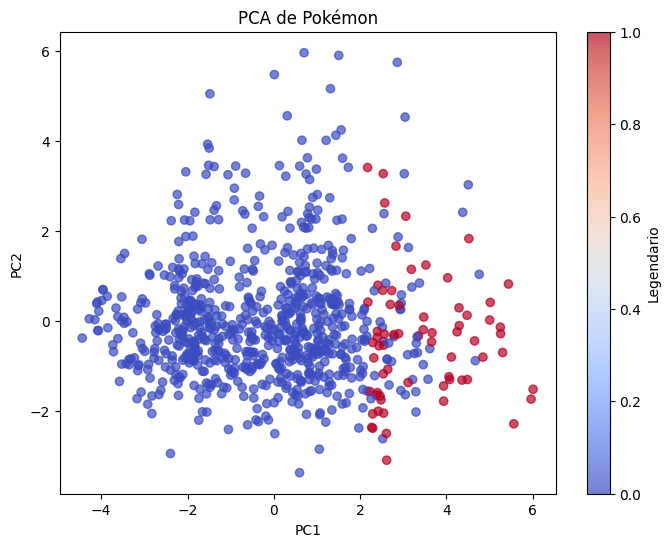

In [40]:
X = dataset.drop(["Legendary"], axis=1)
X_scaled = StandardScaler().fit_transform(X)

# Aplica PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualiza, coloreando por legendario
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=dataset["Legendary"], cmap='coolwarm', alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA de Pokémon")
plt.colorbar(label="Legendario")
plt.show()

### Respuestas Problema 2
El Grafico que se genero gracias a PCA, podemos apreciar que los pokemones no legendarios(Color azul) se agrupan en una region un poco especifica(En PC1 valores entre -4 y 2 aproximadamente y en PC2 entre -2 y 4), Por otro lado, los pokemones legendarios(Color rojo) tienden a estar en los valores mayores a 2 y bastante dispersos en los valores de el eje PC2, mostrando que estos poseen caracteristicas que totalmente los hacen diferentes a los no legendarios en un espacio reducido por PCA, aunque presentan una variabilidad alta en ciertos casos, aunque todos se juntan en un punto.  
Esto indica que las variables del dataset permiten distinguir a los legendarios de los no legendarios en el espacio reducido, lo que concuerda con los resultados obtenidos en el problema anterior.